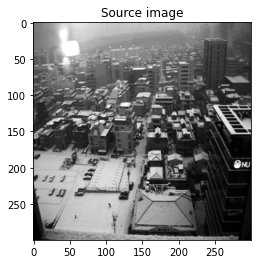

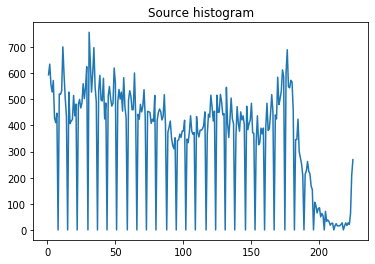

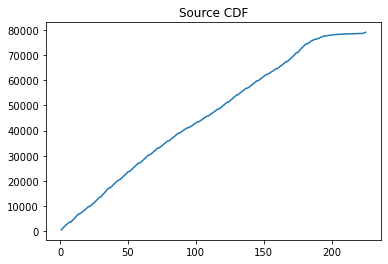

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, transform

def adap_hist_matching(source_im, target_im, D):
    
    if(source_im.shape[0] % D != 0 or source_im.shape[1] % D != 0):
        raise NameError("Source must be a square with shapes devideble by {}, but you have width: {} and height: {}".format(D, source_im.shape[0], source_im.shape[1]))
    
    #get a count of steps (count of boxes in the grid)
    steps = (source_im.shape[0] // D) ** 2
    #get a target_im width, height and pixels count
    width_t = target_im.shape[0]
    height_t = target_im.shape[1]
    pixels_t = width_t * height_t
    
    #calculate a source pixel count
    pixels_s = D ** 2
    
    #get target histogram
    target_hist, tarbet_bin = get_hist(target_im)
    
    #get a target cumulative distribution function
    target_cdf = CDF(target_hist, tarbet_bin)
    
    #get a probability of the pixels
    target_cdf_prob = target_cdf / pixels_t
    
    #start position initialization
    row = 0
    column = 0
    
    row_img = 0
    col_img = 0
    
    out_image_raw = list()
    
    for s in np.arange(steps):
        c2 = column + 1
        r2 = row + 1
        # Cut the image
        source_cropped = cut_image(source_im.copy(), D*row, D*column, D*r2, D*c2)
        
        #get a cutted histogram
        source_hist, source_bin = get_hist(source_cropped)

        #find a cumulative distribution function of the cutted img
        source_cdf = CDF(source_hist, source_bin)

        #get probabilities of the source cdf
        source_cdf_prob = source_cdf / pixels_s
        
            
        #calculate a new pixel value by a probabilitie
        K = 256
        new_values = np.zeros((K))
        for a in np.arange(K):
            j = 255
            while True:
                new_values[a] = j
                j = j - 1
                if j < 0 or source_cdf_prob[a] > target_cdf_prob[j]:
                    break

        #apply new value for each source pixel
        for i in np.arange(D):
            for j in np.arange(D):
                a = source_cropped.item(i,j)
                b = new_values[a]

                source_cropped.itemset((i,j), b)
        
        if(column == source_im.shape[0] / D - 1):
            row += 1
            column = 0
        else:
            column += 1
        
        out_image_raw.append(source_cropped)
    
    #concatenate grid parts to one image
    index = 0
    vertically_parts = np.array([], dtype=np.int64).reshape(0,D)
    out_im = np.array([], dtype=np.int64).reshape(source_im.shape[0],0)
    for part in out_image_raw:
        vertically_parts = np.vstack([vertically_parts, part])
        if(index == source_im.shape[0] / D - 1):
            out_im = np.hstack([out_im, vertically_parts])
            vertically_parts = np.array([], dtype=np.int64).reshape(0,D)
            index = 0
        else:
            index += 1
    return out_im

def load_image(path):
    return io.imread(path) if path is not None else None

def cut_image(source, x1, y1, x2, y2):
    return source[y1:y2, x1:x2]

def get_hist(image):
    return np.histogram(image, bins = 256)

def CDF(hist, b):
    dx = b[1] - b[0]
    return np.cumsum(hist) * dx
    
D = 50
target = load_image("ref.jpg")
source = load_image("adj.jpg")
source = np.round(transform.resize(source, (300,300))*225).astype(int)
out_im = adap_hist_matching(source.copy(), target.copy(), D)
hist_t, b_t = get_hist(target)
hist_s, b_s = get_hist(source)
hist_o, b_o = get_hist(out_im)
cdf_t = CDF(hist_t, b_t)
cdf_s = CDF(hist_s, b_s)
cdf_o = CDF(hist_o, b_o)
plt.figure()
plt.title("Source image")
plt.imshow(source, cmap='gray')
plt.figure()
plt.title("Source histogram")
plt.plot(b_s[1:], hist_s)
plt.figure()
plt.title("Source CDF")
plt.plot(b_s[1:], cdf_s)

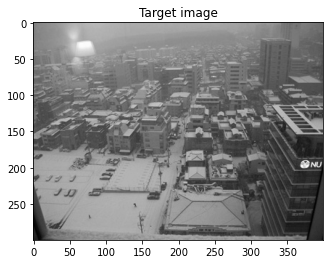

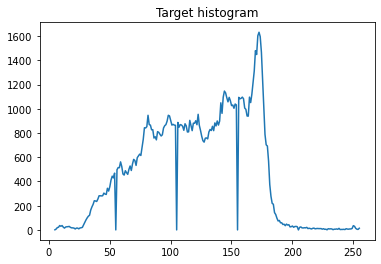

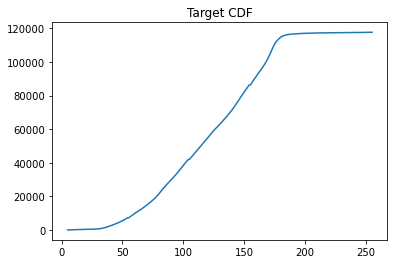

In [34]:
plt.figure()
plt.title("Target image")
plt.imshow(target, cmap='gray')
plt.figure()
plt.title("Target histogram")
plt.plot(b_t[1:], hist_t)
plt.figure()
plt.title("Target CDF")
plt.plot(b_t[1:], cdf_t)

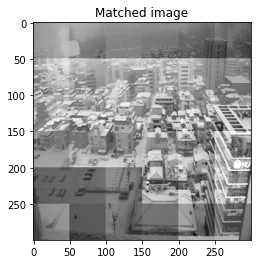

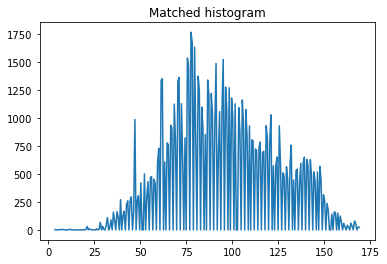

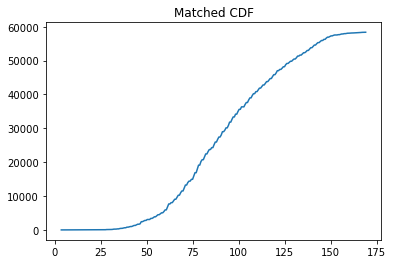

In [33]:
plt.figure()
plt.title("Matched image")
plt.imshow(out_im, cmap='gray')
plt.figure()
plt.title("Matched histogram")
plt.plot(b_o[1:], hist_o)
plt.figure()
plt.title("Matched CDF")
plt.plot(b_o[1:], cdf_o)